In [1]:
from helpers import ImageManager
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from sklearn.decomposition import PCA

In [2]:
def plot(dim, figsize, imgs, titles=None, gray=False):
    fig, ax = plt.subplots(dim[0], dim[1], figsize=figsize)
    ax = ax.flatten()
    for i in range(len(imgs)):
        if gray:
            ax[i].imshow(imgs[i], cmap='gray'), ax[i].set_xticks([]), ax[i].set_yticks([])
        else:
            ax[i].imshow(imgs[i]), ax[i].set_xticks([]), ax[i].set_yticks([])
        
        if titles:
            ax[i].set_title(titles[i])

In [3]:
np.random.seed(0)
def load_datasets(color=cv2.COLOR_BGR2RGB):
    abdullah_base = './images/Abdullah/'
    mustafa_base = './images/Mustafa/'
    saleh_base = './images/Saleh/'
    adham_base = './images/Adham/'
    anees_base = './images/Anees/'

    # training images
    traindict = {'abdullah': abdullah_base + 'training/', 'mustafa': mustafa_base + 'training/', 
                 'saleh': saleh_base + 'training/', 'adham': adham_base + 'training/', 
                 'anees': anees_base + 'training/'}
    training_dataset = []
    for label, directory in traindict.items():
        images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
        for img in images:
            training_dataset.append((label, cv2.cvtColor(img, color)))
    np.random.shuffle(training_dataset)
    X_train = np.array([j for _, j in training_dataset])
    Y_train = np.array([i for i, _ in training_dataset])

    # testing images
    testdict = {'abdullah': abdullah_base + 'testing/', 'mustafa': mustafa_base + 'testing/', 
                'saleh': saleh_base + 'testing/', 'adham': adham_base + 'testing/', 
                'anees': anees_base + 'testing/'}
    testing_dataset = []
    for label, directory in testdict.items():
        images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
        for img in images:
            testing_dataset.append((label, cv2.cvtColor(img, color)))
    np.random.shuffle(testing_dataset)
    X_test = np.array([j for _, j in testing_dataset])
    Y_test = np.array([i for i, _ in testing_dataset])

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_datasets(color=cv2.COLOR_BGR2GRAY)

In [4]:
# Get Data using the Helper Class
mng = ImageManager()
mng.training_images = X_train
mng.testing_images = X_test
# testing_images = mng.get_testing_images(color=cv2.COLOR_BGR2GRAY)
# training_images = mng.get_training_images(color=cv2.COLOR_BGR2GRAY)
group_images = mng.get_group_images()
_, _ = mng.update_testing_bounds()
_, _ = mng.update_training_bounds()
testing_faces = mng.testing_faces
training_faces = mng.training_faces

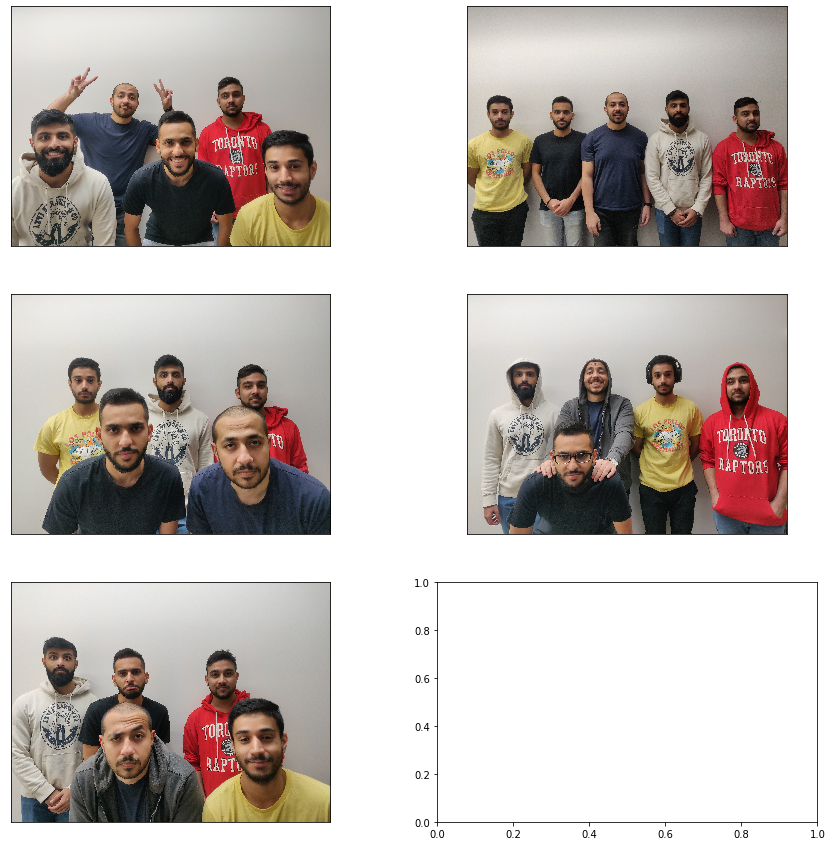

In [5]:
plot((3, 2), (15, 15), group_images)

group_images_gray = []
for img in group_images:
    group_images_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
# plot((3, 2), (15, 15), group_images_gray, gray=True)

## Face Extraction

In [6]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [7]:
faces = []
for i, img_gray in enumerate(group_images_gray):
    faces.append(
        faceCascade.detectMultiScale(img_gray, scaleFactor=1.2, minNeighbors=6, 
                                     minSize=(100, 100), flags = cv2.CASCADE_SCALE_IMAGE)
    )
    print("Found {} faces! for image_gray[{}]".format(len(faces[-1]), i))

Found 5 faces! for image_gray[0]
Found 5 faces! for image_gray[1]
Found 5 faces! for image_gray[2]
Found 5 faces! for image_gray[3]
Found 5 faces! for image_gray[4]


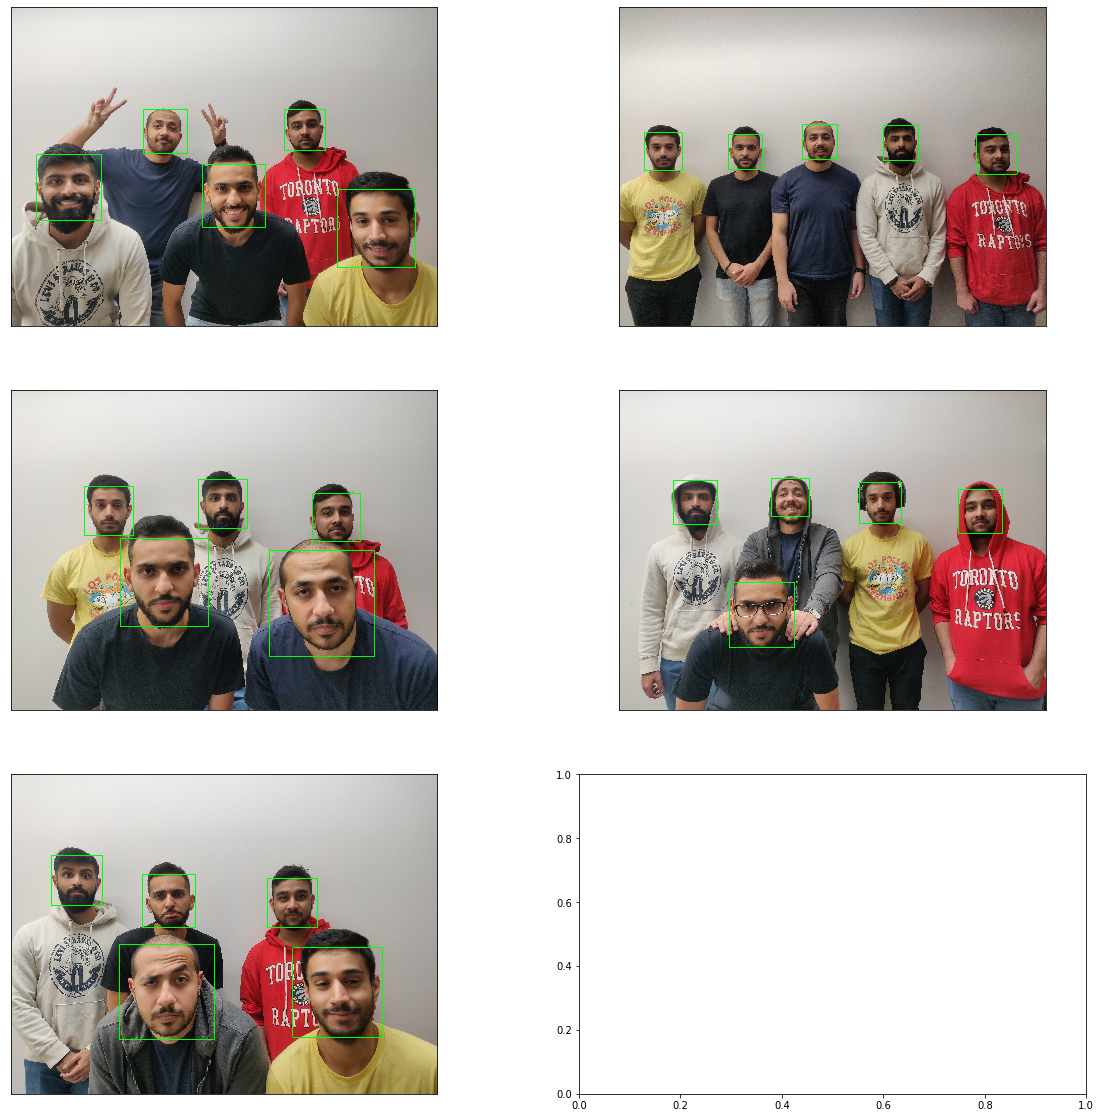

In [8]:
# Draw a rectangle around the faces
for i, detected_faces in enumerate(faces):
    for (x, y, w, h) in detected_faces:
        cv2.rectangle(group_images[i], (x, y), (x+w, y+h), (0, 255, 0), 10)
plot((3, 2), (20, 20), group_images)

In [9]:
extracted_faces_labels = [['anees', 'adham', 'abdullah', 'saleh', 'mustafa'], 
                          ['adham', 'abdullah', 'mustafa', 'saleh', 'anees'], 
                          ['abdullah', 'mustafa', 'anees', 'saleh', 'adham'], 
                          ['adham', 'abdullah', 'mustafa', 'anees', 'saleh'], 
                          ['abdullah', 'saleh', 'anees', 'adham', 'mustafa']]

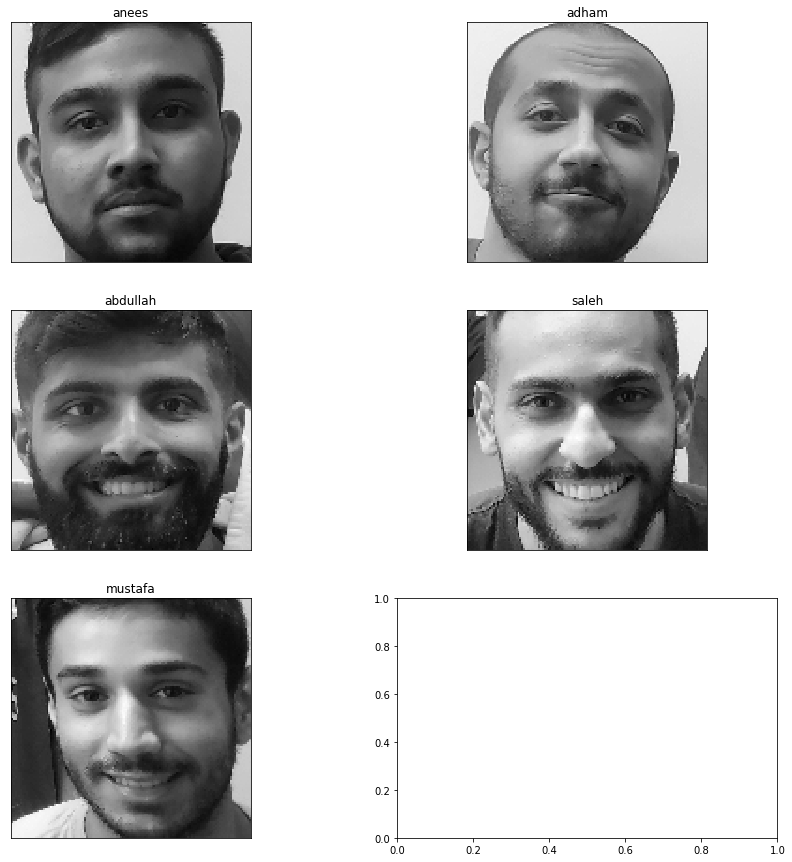

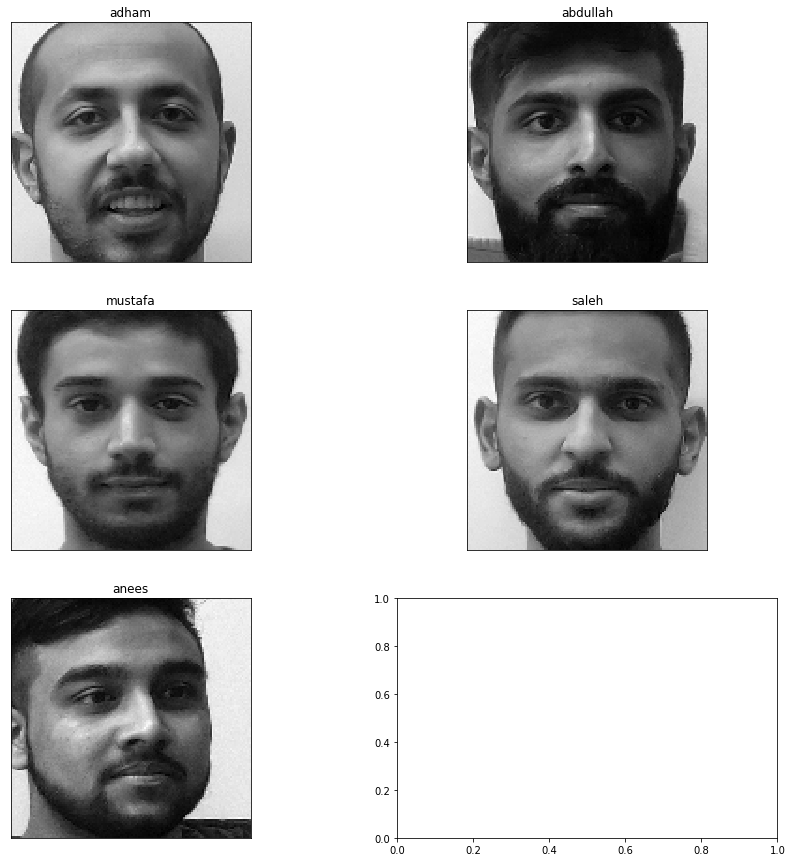

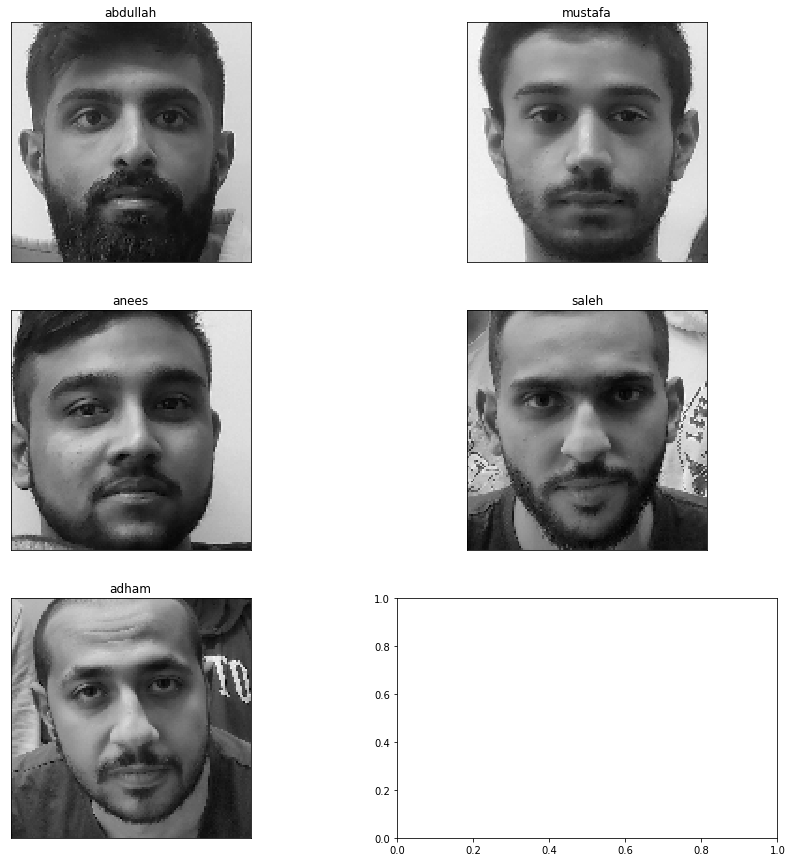

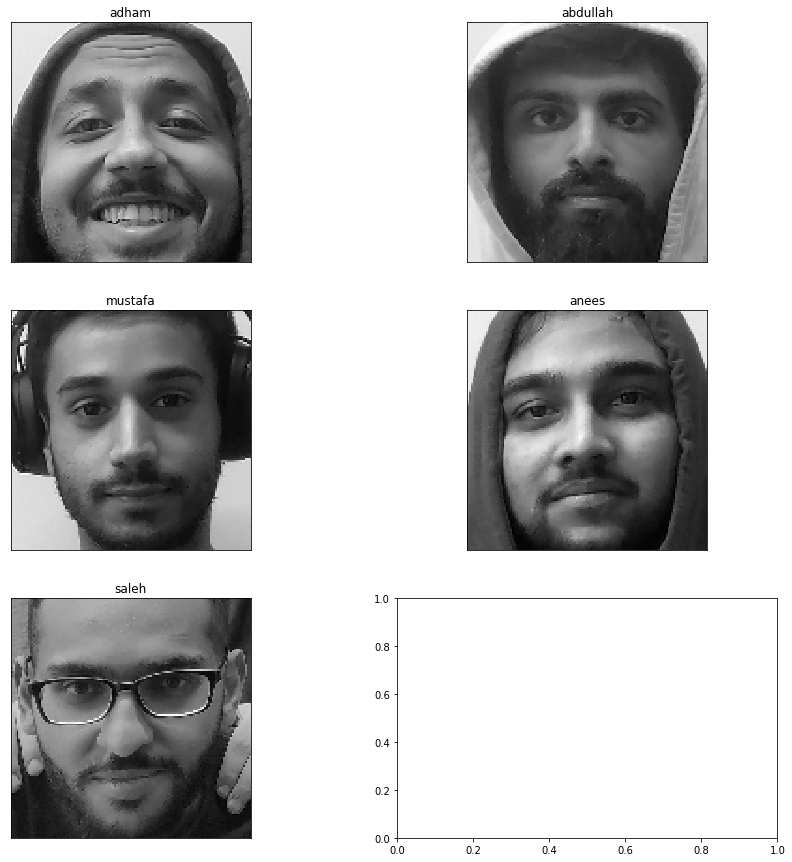

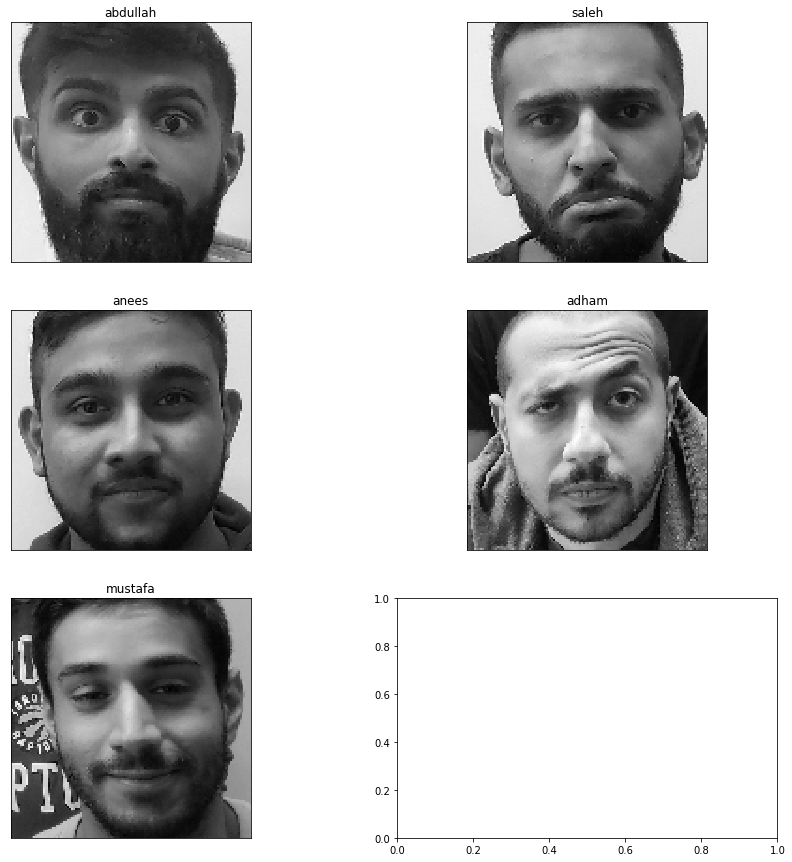

In [10]:
extracted_faces = [mng.extract_faces(group_images_gray[i], faces[i]) for i, _ in enumerate(faces)]
for i, imgs in enumerate(extracted_faces):
    plot((3, 2), (15, 15), imgs, extracted_faces_labels[i], gray=True)

# PCA

In [11]:
# Number of Features/Eigenfaces used in PCA (optimized)
NC = 15
X_train_faces = np.array([i.flatten() for i in training_faces])
pca = PCA(n_components=NC)
pca.fit(X_train_faces)
X_train_faces_pca = pca.transform(X_train_faces)

# Transforming test dataset using the trained PCA
X_test_faces = np.array([i.flatten() for i in testing_faces])
X_test_faces_pca = pca.transform(X_test_faces)

# List to hold 1 or 0 depending on predictions 
correct = []
for i, _ in enumerate(X_test_faces_pca):
    # Getting the index of the closest eigen face from the training set
    index = np.argmin(np.linalg.norm(X_test_faces_pca[i] - X_train_faces_pca, axis=1))

    # Comparing the labels
#     print('Predicted = {}\t|\tActual = {}'.format(Y_train[index], Y_test[i]))

    # Adding 1 to a list if prediction is correct
    correct.append(Y_train[index] == Y_test[i])

accuracy = sum(correct)/len(X_test_faces_pca)
print('\nAccuracy = {:.3f}'.format(accuracy))


Accuracy = 0.543


In [12]:
# Transforming test dataset using the trained PCA
faces_extracted = [face for faces in extracted_faces for face in faces]
X_test_faces =  np.array([i.flatten() for i in faces_extracted])
X_test_faces_pca = pca.transform(X_test_faces)
Y_test_faces = [face for faces in extracted_faces_labels for face in faces]

# List to hold 1 or 0 depending on predictions 
correct = []
for i, _ in enumerate(X_test_faces_pca):
    # Getting the index of the closest eigen face from the training set
    index = np.argmin(np.linalg.norm(X_test_faces_pca[i] - X_train_faces_pca, axis=1))

    # Comparing the labels
#     print('Predicted = {}\t|\tActual = {}'.format(Y_train[index], Y_test[i]))

    # Adding 1 to a list if prediction is correct
    correct.append(Y_train[index] == Y_test[i])

accuracy = sum(correct)/len(X_test_faces_pca)
print('\nAccuracy = {:.3f}'.format(accuracy))


Accuracy = 0.160
